https://arxiv.org/pdf/1511.06434.pdf

#### DCGAN

通常の畳み込みを使ったGANとの違いは、
- プーリング層を使わず識別器ではConvolution層のstrideで、生成器ではfractional-strided-convolution(逆畳み込み)で画像のサイズを変換する
- 識別器・生成器共にBatchNormalizationを使用
- 全結合層を除外
- 生成器における活性化関数は出力のTanhを除いてすべてReLUを使用する
- 識別器ではすべての活性化関数をLeakyReLUとする(確率を出力する際はsigmoidを使用)

LeakyReLUの$\alpha$は0.2とします。

生成器の構造を図に示す。
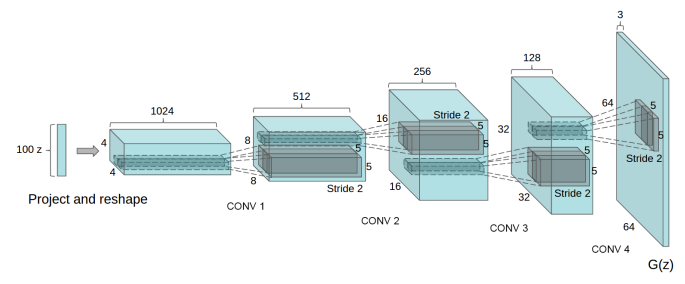



最適化手法はAdamを使用し、学習率は0.0002、$\beta_1$は0.5とする。

#### 識別器の損失関数
GANの損失関数は次の式となる。
$$
\min_G\max_D L(D,G)=E_{x\sim p_{data}(x)}[\log D(x)]+E_{z\sim p_{z}(z)}[\log(1- D(G(z)))]
$$
損失関数$L(D,G)$は識別器が最大化、生成器が最小化する。
識別器と生成器は交互に学習するため、$L(D)$と$L(G)$の2つに分けて考える。
識別器の損失関数$L(d)$は符号を逆にして、最小化問題として考える。
$$
L(D,G)=-E_{x\sim p_{data}(x)}[\log D(x)]-E_{z\sim p_{z}(z)}[\log(1- D(G(z)))]
$$
本物画像の入力時は識別信号$D(x)$を出力し、生成画像の入力時は識別信号$D(G(z))$を出力する。
第1項は$D(x)$が1のときに損失が0となり、第2項は$D(G(z))$が0のときに損失が0となる。
識別器の損失関数はバイナリークロスエントロピーで定式化できる。
$$
J^D=-y\log D(x)-(1-y)\log (1-D(G(z)))
$$

#### 生成器の損失関数
$L(D,G)$の最小化を行う。
$$
\min_G\max_D L(D,G)=E_{x\sim p_{data}(x)}[\log D(x)]+E_{z\sim p_{z}(z)}[\log(1- D(G(z)))]
$$
第1項はノイズに対して定数となるので、第2項だけ使用する。
$$
L(G)=E_{z\sim p_{z}(z)}[\log(1- D(G(z)))]
$$
識別器をだますことができれば、$D(G(z))=1$で損失関数はマイナス無限大となり最小化する。
この関数であると、0付近で勾配が小さく、学習が進まないという問題があるので次のように書き替える。
$$
L(G)=-E_{z\sim p_{z}(z)}[\log(D(G(z)))]
$$
生成器の損失関数もバイナリークロスエントロピーで定式化できる。
$$
J^G=-J^D=y\log D(x)+(1-y)\log (1-D(G(z)))
$$
生成器では$y=0$の生成画像クラスだけを使用する
$$
J^G=\log (1-D(G(z)))
$$
さらに、$L(G)$と同様に書き換える。
$$
J^G=-\log D(G(z))
$$
この式はバイナリークロスエントロピーの$J^G=-y\log D(G(z))$の$y=1$の式と同じで、正解ラベルは$y=1$と考える。

In [1]:
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Conv2D, Conv2DTranspose, Activation, MaxPooling2D, Flatten, LeakyReLU, Dropout, GlobalAveragePooling2D, BatchNormalization, Reshape
from tensorflow.keras import regularizers
from tensorflow.keras import initializers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from keras.datasets import mnist
import numpy as np
import cv2

import matplotlib.pyplot as plt

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = (x_train.astype('float32')-127.5) / 127.5
x_test = (x_test.astype('float32')-127.5) / 127.5
x_train = x_train.reshape(len(x_train), 28, 28, 1)
x_test = x_test.reshape(len(x_test), 28, 28, 1)

In [3]:
class gen_conv(Model):
    """Generator用のConvulution"""
    def __init__(self, out_channels, kernel_size=5, stride=2, padding='same', final=False):
        super().__init__()
        if final:
            # 最後の層だけtanh
            self.act = Activation("tanh")
            self.bn = False
        else:
            # 最後の層以外はReLU
            self.act = Activation("relu")
            self.bn = True
        
        # 拡張していく
        self.conv = Conv2DTranspose(out_channels,
                                    kernel_size=kernel_size,
                                    strides=stride,
                                    padding=padding,
                                    use_bias=False)
        
        if self.bn:
            self.bn = BatchNormalization(momentum=0.8)
    
    def call(self, x):
        x = self.conv(x)
        if self.bn:
            x = self.bn(x)
        x = self.act(x)
        
        return x

In [4]:
class Generator(Model):
    """Generator"""
    def __init__(self, z_dim=100, image_dim=1, img_size=28, hidden_dim=128):
        super().__init__()
        self.z = z_dim
        
        self.gen1 = gen_conv(out_channels=hidden_dim*4, kernel_size=3, stride=1, padding='valid')
        self.gen2 = gen_conv(out_channels=hidden_dim*2, kernel_size=3, stride=2, padding='valid')
        self.gen3 = gen_conv(out_channels=hidden_dim, kernel_size=5, stride=2, padding='same')
        
        self.out = gen_conv(out_channels=image_dim, kernel_size=5, stride=2, padding='same', final=True)
        
    def call(self, x):
        x = Reshape(target_shape=(1,1,self.z))(x)
        x = self.gen1(x)
        x = self.gen2(x)
        x = self.gen3(x)
        x = self.out(x)
        
        return x

In [5]:
gen = Generator()
gen.build((None,100))  # build with input shape.
dummy_input = Input(shape=(100))  # declare without batch demension.
model_summary = Model(inputs=[dummy_input], outputs=gen.call(dummy_input))
model_summary.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 reshape (Reshape)           (None, 1, 1, 100)         0         
                                                                 
 gen_conv (gen_conv)         (None, 3, 3, 512)         462848    
                                                                 
 gen_conv_1 (gen_conv)       (None, 7, 7, 256)         1180672   
                                                                 
 gen_conv_2 (gen_conv)       (None, 14, 14, 128)       819712    
                                                                 
 gen_conv_3 (gen_conv)       (None, 28, 28, 1)         3200      
                                                                 
Total params: 2,466,432
Trainable params: 2,464,640
Non-train

In [6]:
class disc_conv(Model):
    """Discriminator用のConvulution"""
    def __init__(self, out_channels, kernel_size=5, stride=2, padding='same', final=False):
        super().__init__()
        if final:
            self.act = Activation("sigmoid")
        else:
            self.act = LeakyReLU(alpha=0.2)
        
        self.conv = Conv2D(out_channels,
                           kernel_size=kernel_size,
                           strides=stride,
                           padding=padding,
                           use_bias=False)
        self.bn = BatchNormalization(momentum=0.8)
        
    def call(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.act(x)
        
        return x

In [7]:
class Discriminator(Model):
    """Discriminator"""
    def __init__(self, img_size=28, hidden_dim=128):
        super().__init__()
        self.disc1 = disc_conv(out_channels=hidden_dim, kernel_size=5, stride=2, padding='same')
        self.disc2 = disc_conv(out_channels=hidden_dim*2, kernel_size=5, stride=2, padding='same')
        self.disc3 = disc_conv(out_channels=hidden_dim*4, kernel_size=3, stride=2, padding='valid')

        self.out = disc_conv(out_channels=1, kernel_size=3, stride=1, padding='valid', final=True)
        
    def call(self, x):
        x = self.disc1(x)
        x = self.disc2(x)
        x = self.disc3(x)
        x = self.out(x)
        
        return Reshape((-1,))(x)

In [8]:
disc = Discriminator()
disc.build((None,28,28,1))  # build with input shape.
dummy_input = Input(shape=(28,28,1))  # declare without batch demension.
model_summary = Model(inputs=[dummy_input], outputs=disc.call(dummy_input))
model_summary.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 disc_conv (disc_conv)       (None, 14, 14, 128)       3712      
                                                                 
 disc_conv_1 (disc_conv)     (None, 7, 7, 256)         820224    
                                                                 
 disc_conv_2 (disc_conv)     (None, 3, 3, 512)         1181696   
                                                                 
 disc_conv_3 (disc_conv)     (None, 1, 1, 1)           4612      
                                                                 
 reshape_1 (Reshape)         (None, 1)                 0         
                                                                 
Total params: 2,010,244
Trainable params: 2,008,450
Non-tra

In [9]:
class GAN(Model):
    def __init__(self, Discriminator, Generator):
        super().__init__()
        self.gen = Generator
        self.disc = Discriminator
    
    def call(self, x):
        x = self.gen(x)
        x = self.disc(x)
        
        return x

In [10]:
model = GAN(disc,gen)
model.build((None,100))  # build with input shape.
dummy_input = Input(shape=(100))  # declare without batch demension.
model_summary = Model(inputs=[dummy_input], outputs=model.call(dummy_input))
model_summary.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 100)]             0         
                                                                 
 generator (Generator)       (None, 28, 28, 1)         2466432   
                                                                 
 discriminator (Discriminato  (None, 1)                2010244   
 r)                                                              
                                                                 
Total params: 4,476,676
Trainable params: 4,473,090
Non-trainable params: 3,586
_________________________________________________________________


In [12]:
n_noise = 100

optim = Adam(learning_rate=0.0002, beta_1=0.5, beta_2=0.999)
loss =  keras.losses.BinaryCrossentropy(from_logits=True)

discriminator = Discriminator()
discriminator.compile(loss=loss, optimizer=optim, metrics=['accuracy'])

# discriminatorのcompile後にFalseとする(compileしたものには影響がない)
discriminator.trainable = False

optim = Adam(learning_rate=0.0002, beta_1=0.5, beta_2=0.999)
loss =  keras.losses.BinaryCrossentropy(from_logits=True)

generator = Generator()
gan = GAN(discriminator, generator)
gan.compile(loss=loss, optimizer=optim, metrics=['accuracy'])

In [13]:
n_learn = 20001
interval = 1000
batch_size = 128
img_size = 28

real = np.ones((batch_size, 1)).astype(int)
fake= np.zeros((batch_size, 1)).astype(int)

gan_error_record = np.zeros((n_learn, 2))
gan_acc_record = np.zeros((n_learn, 2))

for i in range(n_learn):
    
    #----------------------
    # Discriminatorの訓練
    #----------------------
    rand_ids = np.random.randint(len(x_train), size=batch_size)
    imgs_real = x_train[rand_ids]
    
    noise = np.random.normal(0, 1, (batch_size, n_noise))
    imgs_fake = gan.gen(noise)
    
    d_loss_real = discriminator.train_on_batch(imgs_real, real)
    d_loss_fake = discriminator.train_on_batch(imgs_fake, fake)
    d_loss, accuracy = np.add(d_loss_real,d_loss_fake)*0.5
    
    gan_error_record[i][0] = d_loss
    gan_acc_record[i][0] = accuracy
    
    #----------------------
    # Generatorの訓練
    #----------------------
    noise = np.random.normal(0, 1, (batch_size, n_noise))
    gen_imgs = gan.gen(noise)
    g_loss, accuracy = gan.train_on_batch(noise, real)
    
    gan_error_record[i][1] = g_loss
    gan_acc_record[i][1] = accuracy
    
    if i % interval == 0:
        print("n_learn:",i)
        print("Error_fake:",gan_error_record[i][0],
              "Acc_fake:",gan_acc_record[i][0])
        print("Error_real:",gan_error_record[i][1],
              "Acc_real:",gan_acc_record[i][1])
        generate_images(i)

n_learn: 0
Error_fake: 0.7293117642402649 Acc_fake: 0.5078125
Error_real: 0.46247953176498413 Acc_real: 1.0


NameError: name 'generate_images' is not defined

In [39]:
class Generator(Model):
    """Generator2"""
    def __init__(self):
        super().__init__()
        self.linear = Dense(256*7*7)
        
        self.gen1 = gen_conv(out_channels=128, kernel_size=5, stride=1, padding='same')
        self.gen2 = gen_conv(out_channels=64, kernel_size=5, stride=2, padding='same')
        self.gen3 = gen_conv(out_channels=1, kernel_size=5, stride=2, padding='same', final=True)
                
    def call(self, x):
        x = self.linear(x)
        x = Reshape(target_shape=(7,7,256))(x)
        x = self.gen1(x)
        x = self.gen2(x)
        x = self.gen3(x)
        
        return x

In [40]:
gen = Generator()
gen.build((None,100))  # build with input shape.
dummy_input = Input(shape=(100))  # declare without batch demension.
model_summary = Model(inputs=[dummy_input], outputs=gen.call(dummy_input))
model_summary.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 100)]             0         
                                                                 
 dense_3 (Dense)             (None, 12544)             1266944   
                                                                 
 reshape_7 (Reshape)         (None, 7, 7, 256)         0         
                                                                 
 gen_conv_22 (gen_conv)      (None, 7, 7, 128)         819712    
                                                                 
 gen_conv_23 (gen_conv)      (None, 14, 14, 64)        205056    
                                                                 
 gen_conv_24 (gen_conv)      (None, 28, 28, 1)         1604      
                                                                 
Total params: 2,293,316
Trainable params: 2,292,930
Non-tra

In [41]:
class Discriminator(Model):
    def __init__(self):
        super().__init__()
        self.disc1 = disc_conv(out_channels=32, kernel_size=5, stride=2, padding='same')
        self.disc2 = disc_conv(out_channels=64, kernel_size=5, stride=2, padding='same')
        self.disc3 = disc_conv(out_channels=128, kernel_size=5, stride=2, padding='same')
        
        self.flat = Flatten()
        self.out = Dense(1, activation='sigmoid')
                
    def call(self, x):
        x = self.disc1(x)
        x = self.disc2(x)
        x = self.disc3(x)
        
        x = self.flat(x)
        x = self.out(x)
        
        return x

In [42]:
disc = Discriminator()
disc.build((None,28,28,1))  # build with input shape.
dummy_input = Input(shape=(28,28,1))  # declare without batch demension.
model_summary = Model(inputs=[dummy_input], outputs=disc.call(dummy_input))
model_summary.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 28, 28, 1)]       0         
                                                                 
 disc_conv_11 (disc_conv)    (None, 14, 14, 32)        928       
                                                                 
 disc_conv_12 (disc_conv)    (None, 7, 7, 64)          51456     
                                                                 
 disc_conv_13 (disc_conv)    (None, 4, 4, 128)         205312    
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_4 (Dense)             (None, 1)                 2049      
                                                                 
Total params: 259,745
Trainable params: 259,297
Non-traina

In [1]:
import torch
import torch.nn as nn
import torch.optim as optimizers

In [2]:
class gen_conv(nn.Module):
    """Generator用のConvulution"""
    def __init__(self, in_channels, out_channels, kernel_size=5, stride=2, padding='same', final=False):
        super().__init__()
        if final:
            # 最後の層だけtanh
            self.act = nn.Tanh()
            self.bn = False
        else:
            # 最後の層以外はReLU
            self.act = nn.ReLU()
            self.bn = True
            
        # 拡張していく
        self.conv = nn.ConvTranspose2d(in_channels,
                                       out_channels,
                                       kernel_size=kernel_size,
                                       stride=stride,
                                       padding=padding)
        
        if self.bn:
            self.bn = nn.BatchNorm2d(out_channels)
    
    def forward(self, x):
        x = self.conv(x)
        if self.bn:
            x = self.bn(x)
        x = self.act(x)
        
        return x

In [234]:
class Generator(nn.Module):
    """Generator"""
    def __init__(self, z_dim=100, image_dim=1, img_size=28, hidden_dim=128):
        super().__init__()
        self.z = z_dim
        
        self.gen1 = gen_conv(in_channels=z_dim, out_channels=hidden_dim*4, kernel_size=3, stride=1, padding=0)
        self.gen2 = gen_conv(in_channels=hidden_dim*4, out_channels=hidden_dim*2, kernel_size=3, stride=2, padding=0)
        self.gen3 = gen_conv(in_channels=hidden_dim*2, out_channels=hidden_dim, kernel_size=4, stride=2, padding=1)
        
        self.out = gen_conv(in_channels=hidden_dim, out_channels=image_dim, kernel_size=4, stride=2, padding=1, final=True)
        
    def forward(self, x):
        x = x.view(-1,self.z,1,1)
        x = self.gen1(x)
        x = self.gen2(x)
        x = self.gen3(x)
        x = self.out(x)
        
        return x

In [235]:
from torchsummary import summary
summary(Generator(), (100,1,1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 512, 3, 3]         461,312
       BatchNorm2d-2            [-1, 512, 3, 3]           1,024
              ReLU-3            [-1, 512, 3, 3]               0
          gen_conv-4            [-1, 512, 3, 3]               0
   ConvTranspose2d-5            [-1, 256, 7, 7]       1,179,904
       BatchNorm2d-6            [-1, 256, 7, 7]             512
              ReLU-7            [-1, 256, 7, 7]               0
          gen_conv-8            [-1, 256, 7, 7]               0
   ConvTranspose2d-9          [-1, 128, 14, 14]         524,416
      BatchNorm2d-10          [-1, 128, 14, 14]             256
             ReLU-11          [-1, 128, 14, 14]               0
         gen_conv-12          [-1, 128, 14, 14]               0
  ConvTranspose2d-13            [-1, 1, 28, 28]           2,049
             Tanh-14            [-1, 1,

In [236]:
class disc_conv(nn.Module):
    """Discriminator用のConvulution"""
    def __init__(self, in_channels, out_channels, kernel_size=5, stride=2, padding='same', bn=True, final=False):
        super().__init__()
        self.bn = bn
        
        if final:
            self.act = nn.Sigmoid()
        else:
            self.act = nn.LeakyReLU(negative_slope=0.2)
        
        self.conv = nn.Conv2d(in_channels,
                              out_channels,
                              kernel_size=kernel_size,
                              stride=stride,
                              padding=padding)
        
        if self.bn:
            self.bn = nn.BatchNorm2d(out_channels)
        
    def forward(self, x):
        x = self.conv(x)
        if self.bn:
            x = self.bn(x)
        x = self.act(x)
        
        return x

In [237]:
class Discriminator(nn.Module):
    """Discriminator"""
    def __init__(self, img_size=28, hidden_dim=128):
        super().__init__()
        self.disc1 = disc_conv(in_channels=1, out_channels=hidden_dim, kernel_size=5, stride=2, bn=False, padding=2)
        self.disc2 = disc_conv(in_channels=hidden_dim, out_channels=hidden_dim*2, kernel_size=5, stride=2, padding=2)
        self.disc3 = disc_conv(in_channels=hidden_dim*2, out_channels=hidden_dim*4, kernel_size=3, stride=2, padding=0)

        self.out = disc_conv(in_channels=hidden_dim*4, out_channels=1, kernel_size=3, stride=1, padding=0, bn=False, final=True)
        
    def forward(self, x):
        x = self.disc1(x)
        x = self.disc2(x)
        x = self.disc3(x)
        x = self.out(x)
        
        return x.squeeze()

In [238]:
Discriminator()

Discriminator(
  (disc1): disc_conv(
    (act): LeakyReLU(negative_slope=0.2)
    (conv): Conv2d(1, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  )
  (disc2): disc_conv(
    (act): LeakyReLU(negative_slope=0.2)
    (conv): Conv2d(128, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (disc3): disc_conv(
    (act): LeakyReLU(negative_slope=0.2)
    (conv): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2))
    (bn): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (out): disc_conv(
    (act): Sigmoid()
    (conv): Conv2d(512, 1, kernel_size=(3, 3), stride=(1, 1))
  )
)

In [239]:
def generate_images(i, type='numpy'):
    n_rows  =16
    n_cols = 16
    if type=='numpy':
        noise = np.random.normal(0, 1, (n_rows*n_cols, n_noise))
        g_imgs = forward_propagation(noise, gen_layers)
    elif type=='keras':
        noise = np.random.normal(0, 1, (n_rows*n_cols, n_noise))
        g_imgs = gan.gen(noise)
    else:
        noise = torch.randn(n_rows*n_cols, n_noise)
        g_imgs = generator(noise)
        print(g_imgs.shape)
        g_imgs = g_imgs.detach().numpy()
        
    g_imgs = g_imgs/2 + 0.5
    
    img_size_spaced = img_size + 2
    
    matrix_image = np.zeros((img_size_spaced*n_rows,
                             img_size_spaced*n_cols))
    
    for r in range(n_rows):
        for c in range(n_cols):
            g_img = g_imgs[r*n_cols + c].reshape(img_size, img_size)
            top = r*img_size_spaced
            left = c*img_size_spaced
            matrix_image[top:top+img_size, left:left+img_size] = g_img
    
    plt.figure(figsize=(8,8))
    plt.imshow(matrix_image.tolist(), cmap='Greys_r')
    plt.tick_params(labelbottom=False, labelleft=False, bottom=False, left=False)
    plt.show()

In [240]:
def weights_init(m):
    """
    ニューラルネットワークの重みを初期化する。作成したインスタンスに対しapplyメソッドで適用する
    :param m: ニューラルネットワークを構成する層
    """
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:            # 畳み込み層の場合
        m.weight.data.normal_(0.0, 0.02)
        m.bias.data.fill_(0)
    elif classname.find('Linear') != -1:        # 全結合層の場合
        m.weight.data.normal_(0.0, 0.02)
        m.bias.data.fill_(0)
    elif classname.find('BatchNorm') != -1:     # バッチノーマライゼーションの場合
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [241]:
discriminator = Discriminator()
discriminator.apply(weights_init)

generator = Generator()
generator.apply(weights_init)

Generator(
  (gen1): gen_conv(
    (act): ReLU()
    (conv): ConvTranspose2d(100, 512, kernel_size=(3, 3), stride=(1, 1))
    (bn): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (gen2): gen_conv(
    (act): ReLU()
    (conv): ConvTranspose2d(512, 256, kernel_size=(3, 3), stride=(2, 2))
    (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (gen3): gen_conv(
    (act): ReLU()
    (conv): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (out): gen_conv(
    (act): Tanh()
    (conv): ConvTranspose2d(128, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
)

In [242]:
criterion = nn.BCELoss()

optimizerD = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999), weight_decay=1e-5)
optimizerG = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999), weight_decay=1e-5)

n_learn: 0
0.4974825978279114 0.027130041271448135
torch.Size([256, 1, 28, 28])


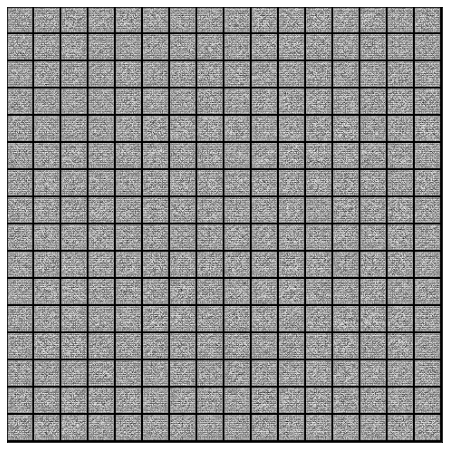

KeyboardInterrupt: 

In [243]:
n_learn = 10001
interval = 1000
batch_size = 32
n_noise=100
img_size=28


real = torch.full((batch_size,),1, dtype=torch.float32)
fake= torch.full((batch_size,),0, dtype=torch.float32)

gan_error_record = np.zeros((n_learn, 2))
gan_acc_record = np.zeros((n_learn, 2))

for i in range(n_learn):
    #----------------------
    # Discriminatorの訓練
    #----------------------
    # 正解画像で損失の計算(正解ラベル:1)
    rand_ids = np.random.randint(len(x_train), size=batch_size)
    imgs_real = torch.tensor(x_train[rand_ids], dtype=torch.float32)
    imgs_real = imgs_real.transpose(3,1)
    
    discriminator.zero_grad()
    output = discriminator(imgs_real)
    d_loss_real = criterion(output, real)
    
    d_x = output.mean().item()
    
    # 生成画像で損失の計算(正解ラベル:0)
    noise = torch.randn(batch_size, n_noise)
    fake_image = generator(noise)
    
    output = discriminator(fake_image)
    d_loss_fake = criterion(output, fake)
    
    d_g_z1 = output.mean().item()
    
    # 2つの損失を足して訓練
    d_loss = d_loss_real+d_loss_fake
    d_loss.backward(retain_graph=True)
    optimizerD.step()
    
    #----------------------
    # Generatorの訓練
    #----------------------
    # 生成画像で損失の計算(正解ラベル:1)
    noise = torch.randn(batch_size, n_noise)
    fake_image = generator(noise)
    
    generator.zero_grad()
    output = discriminator(fake_image)
    g_loss = criterion(output, real)
    
    # 訓練
    g_loss.backward(retain_graph=True)
    d_g_z2 = output.mean().item()
    optimizerG.step()
    
    if i % interval == 0:
        print("n_learn:",i)
        print(d_g_z1,d_g_z2)
        generate_images(i, type='torch')